In [1]:
# gendata (generate data )
# copied from https://github.com/MITgcm/MITgcm/blob/master/verification/tutorial_baroclinic_gyre/input/gendata.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
from scipy.signal import savgol_filter

%matplotlib inline

# define grid spacings and domain

In [24]:
Ho = 4000  # depth of ocean (m)
nx = 930    # gridpoints in x
ny = 1140    # gridpoints in y
xo = 112.5     # origin in x,y for ocean domain
yo = -3.3    # (i.e. southwestern corner of ocean domain)
dx = 1/60     # grid spacing in x (degrees longitude)
dy = 1/60     # grid spacing in y (degrees latitude)
xeast  = xo + (nx-2)*dx   # eastern extent of ocean domain
ynorth = yo + (ny-2)*dy   # northern extent of ocean domain

x = np.linspace(xo-dx, xeast, nx) + dx/2
y = np.linspace(yo-dy, ynorth, ny) + dy/2

nxc = x.size
nyc = y.size

print(f'West BND: {x.min()}, East BND: {x.max()}')
print(f'North BND: {y.min()}, South BND: {y.max()}')
print(f'x size: {nxc}, y size: {nyc}')

West BND: 112.49166666666667, East BND: 127.97500000000001
North BND: -3.308333333333333, South BND: 15.674999999999997
x size: 930, y size: 1140


# 1. load GEBCO topography

In [26]:
ds_topo = xr.open_dataset('topo_sulu_from_gebco.nc')
ds_topo

<xarray.Dataset> Size: 69MB
Dimensions:    (lon: 4800, lat: 7200)
Coordinates:
  * lon        (lon) float64 38kB 110.0 110.0 110.0 110.0 ... 130.0 130.0 130.0
  * lat        (lat) float64 58kB -9.998 -9.994 -9.99 ... 19.99 19.99 20.0
Data variables:
    elevation  (lat, lon) int16 69MB ...

# 1.1 interplate to the model grids

In [76]:
# Prepare the interpolator for the toposulu data
interp_func = RegularGridInterpolator(
    (ds_topo.lat.values, ds_topo.lon.values),
    ds_topo.elevation.values,
    bounds_error=False,
    fill_value=np.nan
)

# Create meshgrid for x and y
X, Y = np.meshgrid(x, y)
points = np.column_stack([Y.ravel(), X.ravel()])

# Interpolate toposulu onto the (x, y) grid
h = interp_func(points).reshape(Y.shape)

h[np.where(h>=0)]=np.nan
h[np.where(h<=-5000)]=-5000

# define patches for isolated water 
patch0 = np.zeros((nyc,nxc)) 
patch1 = np.zeros((nyc,nxc)) 
patch2 = np.zeros((nyc,nxc)) 
patch3 = np.zeros((nyc,nxc)) 
patch4 = np.zeros((nyc,nxc)) 
patch5 = np.zeros((nyc,nxc)) 

patch0x = (x > 112.5) & (x < 114) 
patch0y = (y > -3.3) & (y < -2.5)
patch0[np.ix_(patch0y, patch0x)] = np.nan
patch1x = (x > 120) & (x < 121.25) 
patch1y = (y > -3.3) & (y < -2.6)
patch1[np.ix_(patch1y, patch1x)] = np.nan
patch2x = (x > 127.85) & (x < 128) 
patch2y = (y > -0.2) & (y < 0.5)
patch2[np.ix_(patch2y, patch2x)] = np.nan
patch3x = (x > 127.64) & (x < 128) 
patch3y = (y > 0.7) & (y < 1.3)
patch3[np.ix_(patch3y, patch3x)] = np.nan
patch4x = (x > 127.86) & (x < 128) 
patch4y = (y > 1.9) & (y < 2.1)
patch4[np.ix_(patch4y, patch4x)] = np.nan
patch5x = (x > 127.8) & (x < 128) 
patch5y = (y > 1.7) & (y <= 1.95)
patch5[np.ix_(patch5y, patch5x)] = np.nan
patch = patch0 + patch1 + patch2 + patch3 + patch4 + patch5 +1

h = h*patch

# h.astype('>f4').tofile('bathy_h_fromgebco.bin')

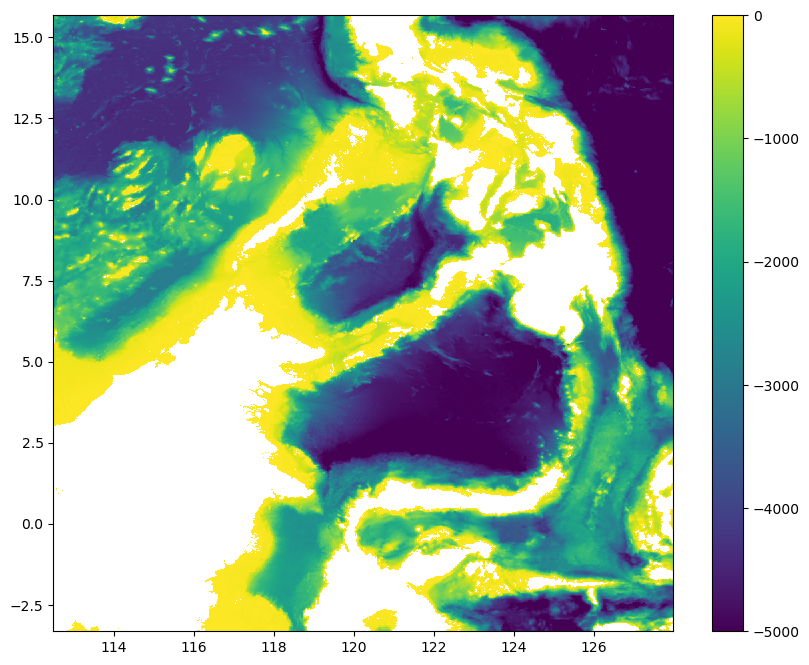

In [79]:
plt.figure(figsize=(10,8))
plt.pcolormesh(x,y,h) #,levels=np.arange(-6000,500,500))
# plt.xlim(127.5,128)
# plt.ylim(-0.5,2.2)
# plt.yticks(np.arange(-0.5,2.3,0.1))
plt.colorbar()
# plt.show()

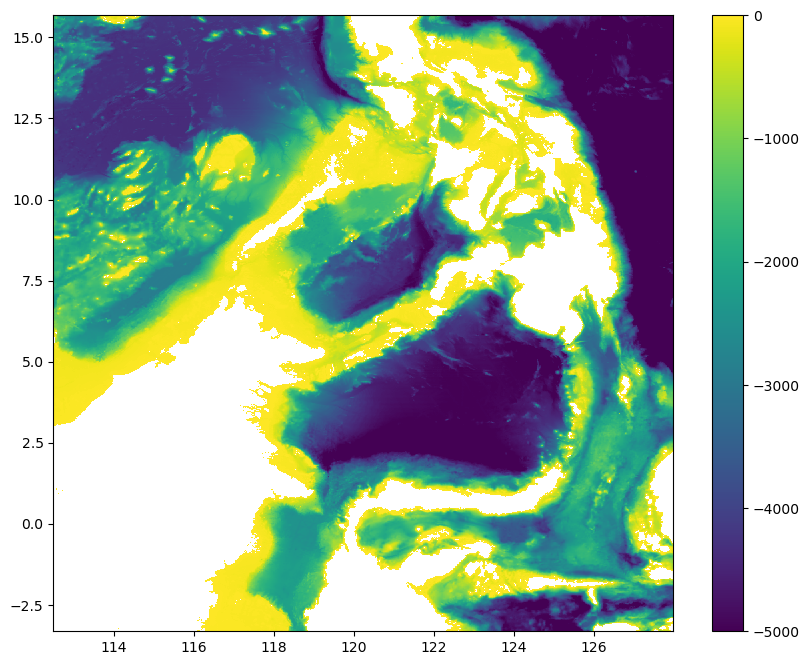

In [80]:
plt.figure(figsize=(10,8))
plt.pcolormesh(x,y,hp1) #,levels=np.arange(-6000,500,500))
plt.colorbar()
# plt.show()

# 2. Get DelZ

In [5]:
Lz_tot = 5000
nzc = 30
mindz = 25
maxdz = 500
target_depth = 700

# Calculate number of points needed to reach target_depth with mindz
n_constant = int(np.floor(target_depth / mindz))

# Create constant spacing for the upper part
constant_part = np.ones(n_constant) * mindz

# Create logarithmic spacing for the lower part
log_part = np.logspace(np.log10(mindz), np.log10(maxdz), nzc)

# Combine the two parts
dz = np.concatenate([constant_part, log_part])

# Apply smoothing (similar to MATLAB's smooth function with span=5)
# Using Savitzky-Golay filter as a good approximation for MATLAB's smooth
dz = savgol_filter(dz, min(5, len(dz) - (1 if len(dz) % 2 == 0 else 0)), 1)
    
tmp = np.cumsum(dz);
# ind = find(tmp<Lz_tot);
ind = np.where(tmp < Lz_tot)[0]

if len(ind) > 0:
        dze = np.max([Lz_tot - tmp[ind[-1]],maxdz])
        # Ensure the total depth is Lz_tot
        dz = np.concatenate([dz[ind], [dze]])

zf = -np.concatenate([[0], np.cumsum(dz)])

# zf = -[0 cumsum(dz)]; % this is RF
z = 0.5 * (zf[:-1] + zf[1:])
    
nzc = len(dz)
# dz.astype('>f4').tofile('delZ.bin')

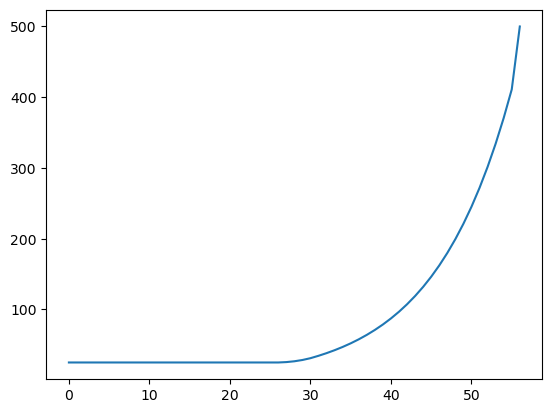

In [6]:
plt.plot(dz)

In [47]:
## write to delZ.bin file
# dz.astype('>f4').tofile('delZ.bin')

# 3. Density Profile

In [7]:
rho0 = 1026.5
alpha = 2e-4

# WOA 2018 averaged in Sulu Sea
dens_profile = pd.read_csv('sulu_sea_density_profile.csv')

# interpolate the density to model z grid. 
dens_interp = np.interp(-z, dens_profile["depth"], dens_profile["potential_density"])
tprofile =  (1-(dens_interp+1000)/rho0)/alpha+5

nxc = x.size
nyc = y.size

# Make sure t is a numpy array (column)
t = np.asarray(tprofile)

# Replicate
T = np.tile(t, (nyc, nxc, 1))
T = np.transpose(T, (2, 0, 1))

U = 0*T
V = 0*T

# T.astype('>f4').tofile('Tinit.bin')
# U.astype('>f4').tofile('Uinit.bin')
# V.astype('>f4').tofile('Vinit.bin')

In [9]:
T.shape

(57, 1140, 930)

# 4. Mask of the sponge zone

In [21]:
nsponge = 1.5 * 60 # 1.5 degree

x0mask = xo+dx*nsponge
y0mask = yo+dy*nsponge

x1mask = xeast-dx*nsponge
y1mask = ynorth-dy*nsponge

x0mask,x1mask,y0mask

maskxy = np.zeros((nyc,nxc))

mask0x = (x > x0mask) & (x < x1mask) 
mask0y = (y > y0mask) & (y < y1mask)
maskxy[np.ix_(mask0y, mask0x)] = 1

mask = np.repeat(maskxy[np.newaxis,:, :], nzc, axis=0)

# mask.astype('>f4').tofile('mask.bin')
# print(mask.shape)  # (len(xc), len(yc), nz)

(57, 1140, 930)


# 5. Boundary conditions

In [17]:
Uzonal = np.zeros([nyc,nzc,2]); # [ny nz nt]
Vzonal = np.zeros([nyc,nzc,2]);
tbnd = T[:,:,1]
Tzonal = np.repeat(tbnd[:, :, np.newaxis], 2, axis=2)
Tzonal = np.transpose(Tzonal, (2, 0, 1))

Umerid = np.zeros([nxc,nzc,2]); # [nz nx nt]
Vmerid = np.zeros([nxc,nzc,2]);
tbnd = T[:,-1,:]
Tmerid = np.repeat(tbnd[:, :, np.newaxis], 2, axis=2)
Tmerid = np.transpose(Tmerid, (2, 0, 1))

# Uzonal.astype('>f4').tofile('Uzonal.bin')
# Vzonal.astype('>f4').tofile('Vzonal.bin')
# Tzonal.astype('>f4').tofile('Tzonal.bin')
# Umerid.astype('>f4').tofile('Umerid.bin')
# Vmerid.astype('>f4').tofile('Vmerid.bin')
# Tmerid.astype('>f4').tofile('Tmerid.bin')

In [19]:
Tzonal.shape

(2, 57, 1140)

# 6. RBCS input data

In [66]:
Lz = 5000
g = 9.81
f = 3.6e-5
# f = 1e-4

cp = np.sqrt(g*Lz);

Ld = cp/f # offshore length scale

vg = np.exp(-y*111e3/Ld);
# UMODE = np.repeat(vg,[nxc 1 nzc]);
UMODE = np.tile(vg, (nzc, nxc, 1))
UMODE.astype('>f4').tofile('umode.bin')

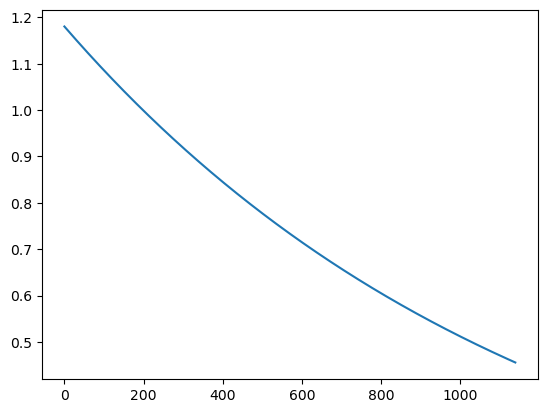

In [62]:
plt.plot(vg)

In [65]:
UMODE.shape

(57, 930, 1140)